# Lecture 2

# Implementation of various sampling and variational methods

In [0]:
!pip install arviz
!pip install pymc3

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 45.3MB/s 
     |████████████████████████████████| 317kB 41.3MB/s 


In [0]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [0]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

# Grid approximation

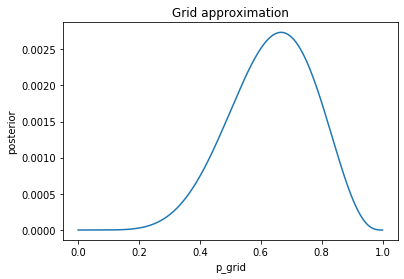

In [0]:
import numpy
import scipy

def quadratic_approx(gridpoints, k, n):
    gridpoints = 1000
    # p_grid 
    p_grid = np.linspace(0, 1, gridpoints)
    p_grid
    # prior
    prior = np.repeat(1, gridpoints)
    prior
    
    # likelihood (probability of the data)
    likelihood = stats.binom.pmf(k, n, p_grid)           
    
    # posterior
    posterior = prior * likelihood
    
    # normalization 
    posterior = posterior/sum(posterior)
    
    # plot
    plt.plot(p_grid, posterior)
    plt.title("Grid approximation")
    plt.xlabel("p_grid")
    plt.ylabel("posterior")
    plt.show()
    
quadratic_approx(5, 6, 9)

# Quadratic approximation

1. Approximating the posterior with a Gaussian distribution. 
2. The region close to the mode of the posterior distribution is more or less normal, and in fact in many cases is actually a Gaussian distribution. 
3. Find the mode of the posterior distribution. This can be done using optimization methods such as finding MAXIMUM APRIORI (MAP). This will be the mean of the approximating Gaussian. 
4. Estimate the curvature of the function near the mode. Based on this curvature, the standard deviation of the approximating Gaussian can be computed.
5. Once we know mean and standard deviation, we understand everything about the disribution. 

## standard deviation calculation
1. Find Hessian matrix which describes the curvature of the function at the maximum. 
2. calculate the inverse of the negative Hessian matrix which will give us the variance and co-variance of our multivariate normal
3. Second derivative of the logarithm of a gaussian distribution is proportional to its inverse squared standard deviation (precision(tau)= 1/sigma**2)


In [0]:
# Quadratic approximation or approximating to the normal
# http://www.sumsar.net/blog/2013/11/easy-laplace-approximation/
# http://canyon289.github.io/pages/InferenceCheatsheet.html
#data = np.repeat((0, 1), (3, 6))
#len(data)
#data.sum()
with pm.Model() as normal_approximation:
    
    # pior
    prior = pm.Uniform('p',0, 1)
    
    # likelihood
    likelihood = pm.Binomial('likelihood', n = 9,p = prior,observed = 6)    
    
    # MAP, you get the mode and mean of the multivariate normal approximation to the posterior
    # mean of the multivariate normal approximation to the posterior
    mean_q = pm.find_MAP()
    
    # standard deviation    
    std_q = ((1/pm.find_hessian(mean_q, vars=[prior]))**0.5)[0]    

mean_q['p'], std_q

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 513.54it/s]


(array(0.66666667), array([0.15713484]))

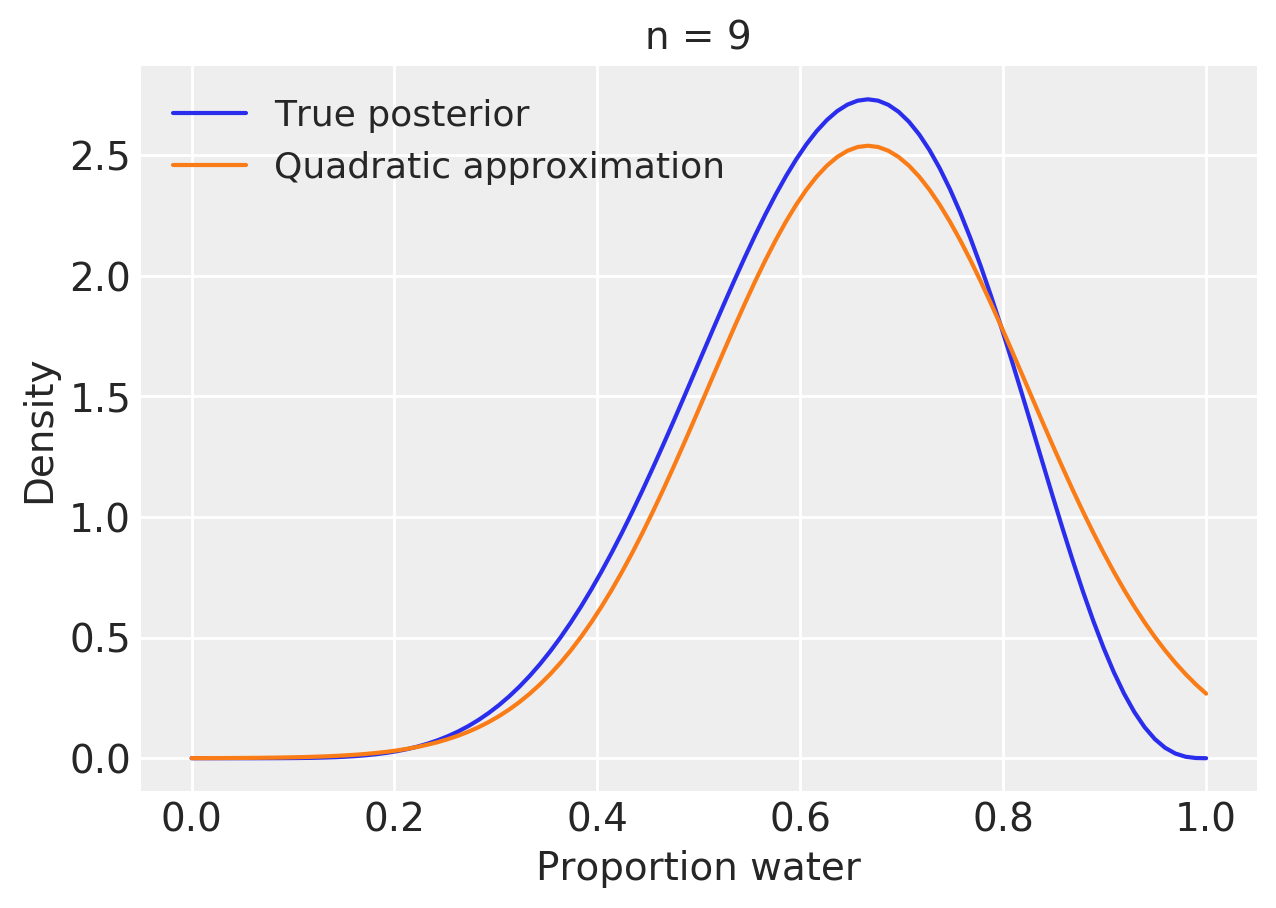

In [0]:
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')
y = stats.norm.pdf(x, mean_q['p'], std_q)
# quadratic approximation
plt.plot(x, y,
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title('n = {}'.format(n), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);

# Metropolis hasting

Sequential sampling (2 chains in 1 job)
Metropolis: [p]
100%|██████████| 1500/1500 [00:00<00:00, 5829.07it/s]
The number of effective samples is smaller than 25% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f283167b0b8>],
      dtype=object)

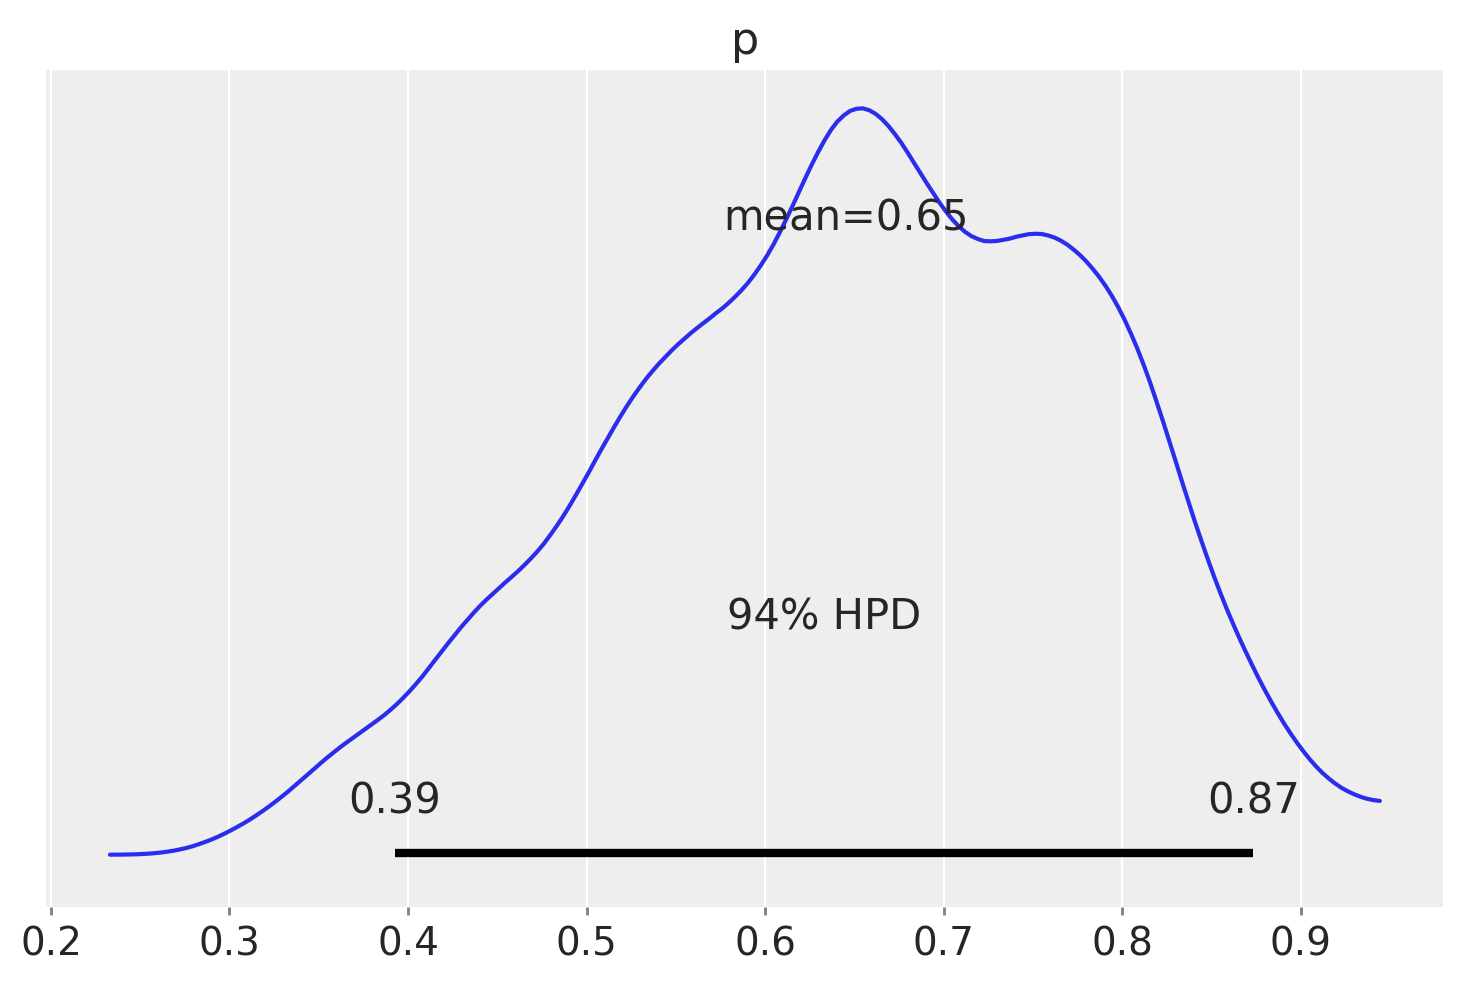

In [0]:
# Random walk metropolis algorithm
# https://twiecki.io/blog/2015/11/10/mcmc-sampling/
# Using a normal to approximate a normal

import pymc3 as pm
import pandas as pd
import arviz as az

with pm.Model() as mcmc_nuts:
    p_water = pm.Uniform("p", 0 ,1)
    w = pm.Binomial("w", p= p_water, n=9, observed=6)
    step = pm.Metropolis()
    trace = pm.sample(1000, step)    
az.plot_posterior(trace)

# Hamiltonian monte carlo

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]
100%|██████████| 510/510 [00:00<00:00, 1404.32it/s]
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ef9ca5160>],
      dtype=object)

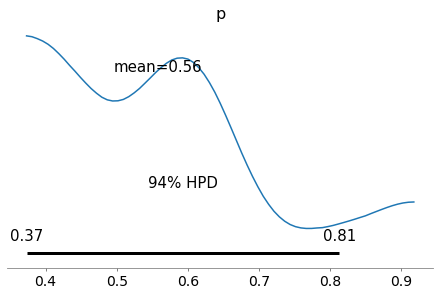

In [0]:
# MCMC Hamiltonian Monte Carlo (No U Turn Sampler)
# canyon289.github.io/pages/InferenceCheatsheet.html

import pymc3 as pm
import pandas as pd
import arviz as az

with pm.Model() as mcmc_nuts:
    p_water = pm.Uniform("p", 0 ,1) # Prior probability for obtaining water
    w = pm.Binomial("w", p= p_water, n=9, observed=6)        
    trace = pm.sample(1000, chains=2)    
az.plot_posterior(trace)

# Variational Inference


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Average Loss = 2.3163: 100%|██████████| 50000/50000 [00:30<00:00, 1622.91it/s]
Finished [100%]: Average Loss = 2.316


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f28284967f0>],
      dtype=object)

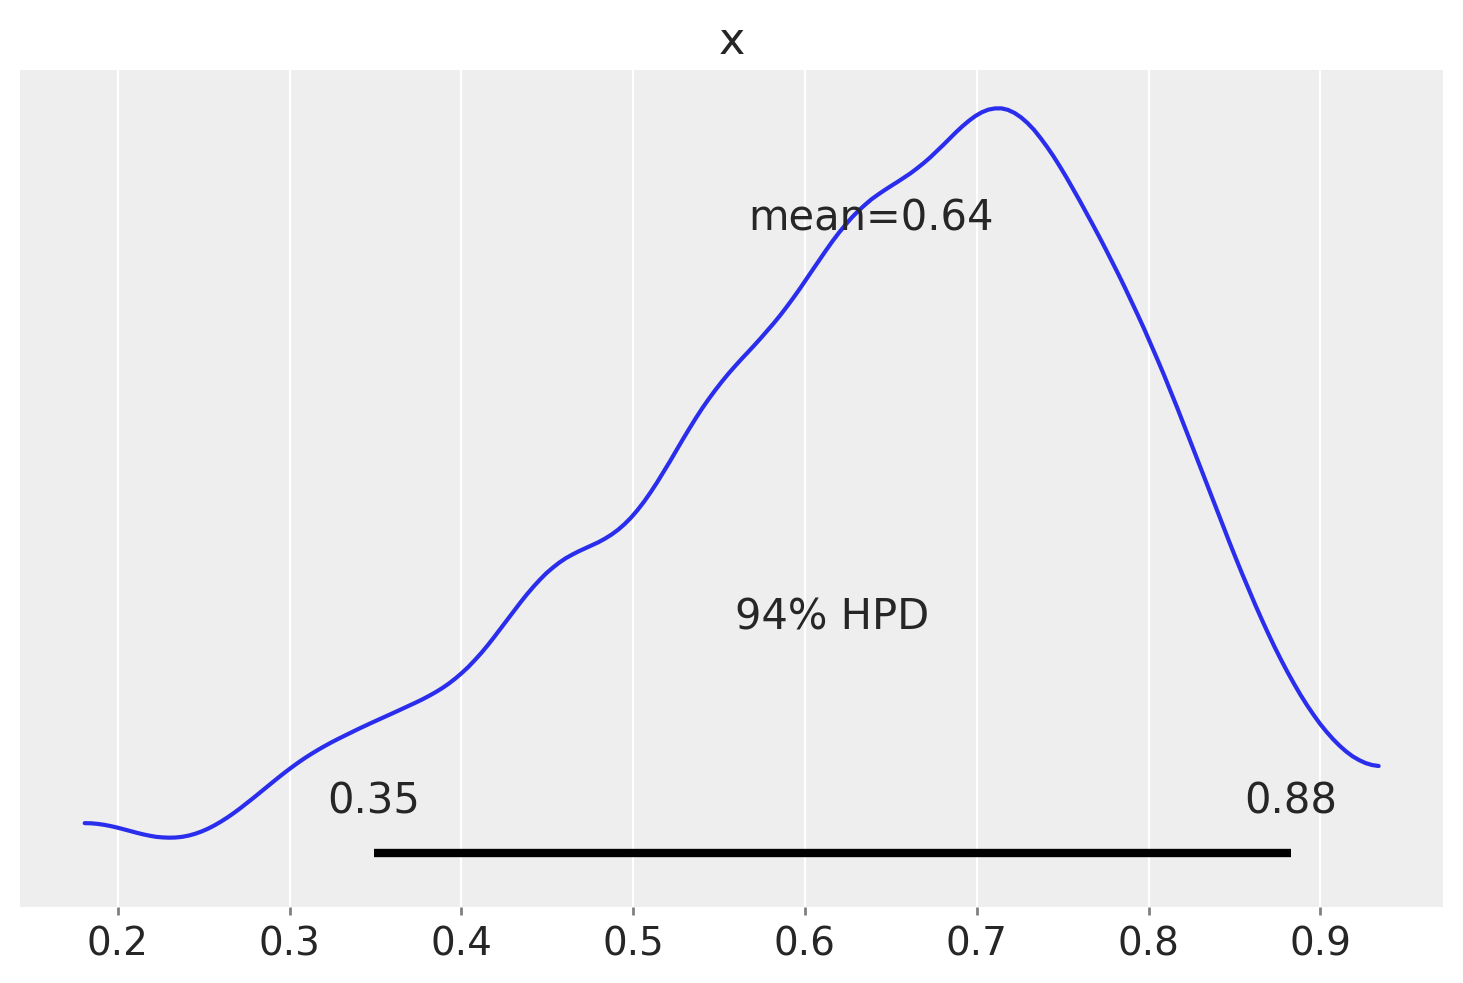

In [0]:
#Variational Inference
with pm.Model() as advi:
    p_water = pm.Uniform("p", 0 ,1)
    w = pm.Binomial("w", p=p_water, n=9, observed=6)
    mean_field = pm.fit(method='advi', n=50000)

advi_samples = mean_field.sample(1000).get_values("p")
az.plot_posterior(advi_samples)

Range of parameter values compatible with model and data.There are many more samples from the dense region near 0.64 and very few samples below 0.3.5. 

1. 94% of interval lies between the 35th percentiles and 88th percentile. HPD stands for higher posterior density. HPD is the region with 94% of the posterior probability. This region always include the most probable parameter value

# End of Week 2 exercise


# Tutorial Reference: 
https://github.com/ahmadsalim/2019-meetup-pyro-intro/blob/master/gaussian_mixture_model.ipynb

In [0]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
import os
os.chdir("/content/gdrive/My Drive/Colab_Notebooks/Bayesian_practice/data")
!ls -l

# Logistic regression

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyro
from pyro import distributions as dist
import torch
from torch.nn import functional as tf
from pyro.infer import SVI, TracePredictive, Trace_ELBO, EmpiricalMarginal
from pyro.infer.mcmc import MCMC, NUTS

%matplotlib inline

In [0]:
data = pd.read_csv("height-weight/NHIS 2007 data.csv", usecols=["SEX", "height", "weight"])
data.columns = ['sex', 'height', 'weight']
# Filter out unknown values
data = data[(data['weight'] < 500) & (data['height'] < 90)]
n_train = len(data) * 3 // 4
train_data, test_data = data[:n_train], data[n_train:]
data.head()

,sex,height,weight
0,1,74,260
1,1,70,185
2,2,61,170
3,1,68,175
4,2,66,168


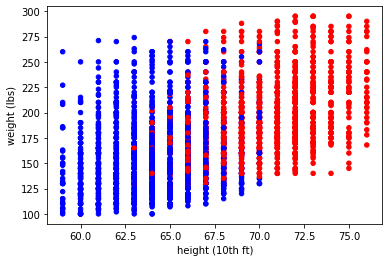

In [0]:
col = train_data['sex'].map({1: 'r', 2: 'b'})
train_data.plot.scatter(x='height', y='weight', color=col)
plt.xlabel('height (10th ft)')
plt.ylabel('weight (lbs)')
plt.show()


We would like to use Bayesian logistic regression to identify the most likely sex of a person given their weight and height.

\begin{gather*}
\mathrm{male?} = \sigma(a_1 * \mathrm{weight} + a_2 * \mathrm{height} + a_0)
\end{gather*}

Below we see an example probabilistic Python program that tries to model the parameters of the logistic regression.

In [0]:
def model(height, weight, sex=None):
    a = pyro.sample('a', dist.MultivariateNormal(torch.zeros(3), torch.eye(3)))
    datavec = torch.stack([torch.ones_like(height), height, weight], dim=-1).float()
    reg = a @ datavec.t()
    if sex is not None:
        sex = (sex == 1).float()
    return pyro.sample('sex', dist.Bernoulli(logits=reg), obs=sex)

In [0]:
height = torch.tensor(train_data['height'].values)
weight = torch.tensor(train_data['weight'].values)
sex = torch.tensor(train_data['sex'].values)
nuts_kernel = NUTS(model)
posterior = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200).run(height, weight, sex=sex)

Sample: 100%|██████████| 1200/1200 [12:50,  1.56it/s, step size=2.62e-03, acc. prob=0.937]


In [0]:
posterior_predictive = TracePredictive(model, posterior, num_samples=100)

/usr/local/lib/python3.6/dist-packages/pyro/infer/abstract_infer.py:298: FutureWarning: The `TracePredictive` class is deprecated and will be removed in a future release. Use the `pyro.infer.Predictive` class instead.
  FutureWarning)


In [0]:
test_height = torch.tensor(test_data['height'].values)
test_weight = torch.tensor(test_data['weight'].values)
test_sex_predict = [t for t,_, _ in posterior_predictive._traces(test_height, test_weight, sex=None)]

AttributeError: ignored

In [0]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
grid = np.mgrid[58:78:500j,90:300:500j]
grid2d = grid.reshape(2, -1)
grid_height = torch.tensor(grid2d[0])
grid_weight = torch.tensor(grid2d[1])
grid_sex_predict = [t for t,_, _ in posterior_predictive._traces(grid_height, grid_weight, sex=None)]
grid_sexes = torch.stack([t.nodes['sex']['value'] for t in grid_sex_predict]).mean(0)
sexes = torch.stack([t.nodes['sex']['value'] for t in test_sex_predict])
mean_sexes = (sexes.mean(0) > 0.5).data.numpy()
testdf = pd.DataFrame({'height': test_data['height'], 'weight': test_data['weight'],
                       'pred_sex': mean_sexes })
col = testdf['pred_sex'].map({1: 'r', 0: 'b'})
ax = testdf.plot.scatter(x='height', y='weight', color=col)
ax.contourf(grid[0], grid[1], grid_sexes.view(500, 500).numpy(), cmap=cmap, zorder=-1)

# Gaussian mixture model

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDelta 
from tqdm import tqdm

ModuleNotFoundError: ignored

In [0]:
data = pd.read_csv("drinks/drinks.csv", usecols=["country", "wine_servings", "beer_servings"])
data.columns = ['country', 'wine', 'beer']
data.head()

In [0]:
data.plot.scatter(x='wine', y='beer')
plt.show()

In [0]:
def model(drinks):
    cluster_means_pr = torch.tensor([[5.0, 5.0], [100.0, 250.0], [100.0, 100.0]])
    cluster_variance_pr = torch.eye(2) * 100
    prior_cluster_as = torch.tensor([1.0, 100.0, 100.0])
    ws = pyro.sample('ws', dist.Dirichlet(prior_cluster_as))
    cluster_means = pyro.sample('cluster_means', dist.MultivariateNormal(cluster_means_pr, cluster_variance_pr).to_event())
    cluster_variances = pyro.sample('cluster_variances', dist.HalfNormal(1.0).expand_by([3,2]).to_event()) + 1e-8
    with pyro.plate('drinks', dim=-1):
        cluster = pyro.sample('cluster', dist.Categorical(ws), infer=dict(enumerate='parallel'))
        pyro.sample('obs', dist.MultivariateNormal(cluster_means[cluster], torch.diag_embed(cluster_variances[cluster])), obs=drinks.float())

In [0]:
guide = AutoDelta(poutine.block(model, hide='cluster'))
wine = torch.tensor(data['wine'].values)
beer = torch.tensor(data['beer'].values)
drinks = torch.stack([wine, beer], dim=-1)
optim = Adam(dict(lr=1.0))
loss = TraceEnum_ELBO()
svi = SVI(model, guide, optim, loss)
svi.evaluate_loss(drinks)

In [0]:
progress = tqdm(range(2000))
for i in progress:
    loss = svi.step(drinks)
    progress.set_description(f"Epoch {i}: {loss}")

In [0]:
pred_cluster = torch.stack(
    [pyro.param('auto_ws')[cl] + 
     dist.MultivariateNormal(pyro.param('auto_cluster_means')[cl], 
                             torch.diag_embed(pyro.param('auto_cluster_variances')[cl]))
     .log_prob(drinks.float()) for cl in range(3)], dim=-1).argmax(dim=-1)
df = pd.DataFrame(dict(wine=data['wine'], beer=data['beer'], pred=pred_cluster.numpy()))
col = df['pred'].map({0: 'r', 1:'b', 2:'g'})
df.plot.scatter(x='wine', y='beer', color=col)